In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Let's make a Neural Network! ~~
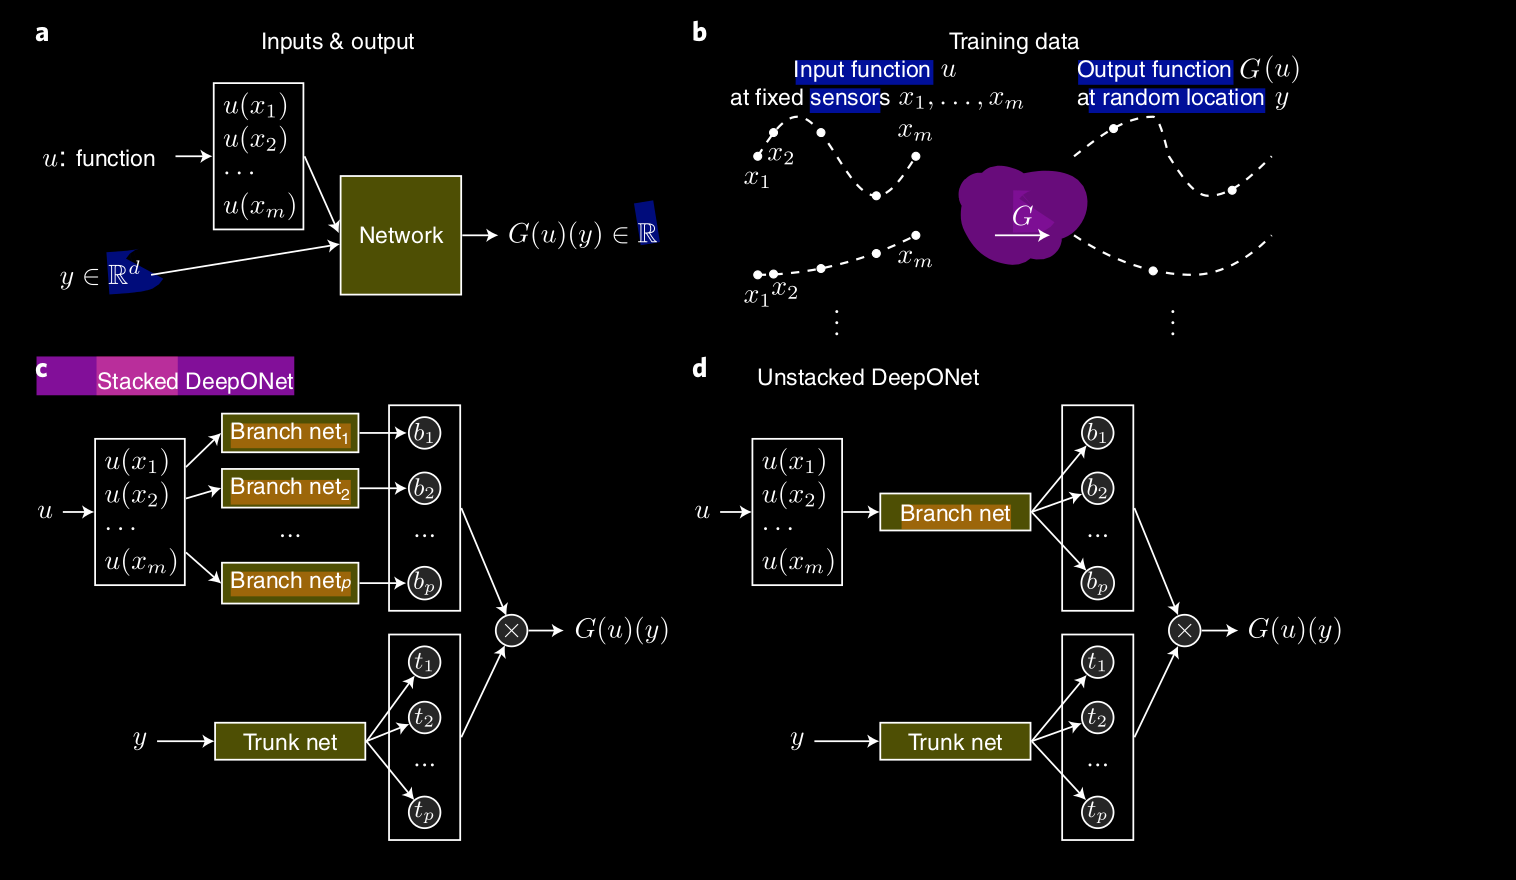

In [2]:
class StackedBranchNet(nn.Module):
    def __init__(self, num_sensors, num_hidden, hidden_size, output_size):
        '''
        num_sensors - we decide in m fixed values of x to sample from different u(x)s
        Here all these inputs share a common set of parameters
        
        '''
        super(StackedBranchNet, self).__init__()
        
        self.input_size = num_sensors
        self.num_hidden = num_hidden
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # NN Architecture ~~
        
        self.input_fc = nn.Linear(self.input_size, hidden_size)
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            hfc = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(hfc)
        
        self.output_fc = nn.Linear(hidden_size, output_size)
        
        # Activation is just LeakyReLU for now
        self.activation = nn.LeakyReLU()
        
        
    def forward(self, x):
        out = self.input_fc(x)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        out = self.output_fc(out)
        return out
    
    
class TrunkNet(nn.Module):
    def __init__(self, num_hidden, hidden_size, output_size):
        super(TrunkNet, self).__init__()
        
        self.num_hidden = num_hidden
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # ~~ NN Architecture ~~
        
        self.input_fc = nn.Linear(1, hidden_size)
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            hfc = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(hfc)
        
        self.output_fc = nn.Linear(hidden_size, output_size)
        
        # Activation is just LeakyReLU for now
        self.activation = nn.LeakyReLU()
        
        
    def forward(self, x):
        out = self.input_fc(x)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        out = self.output_fc(out)
        return out     
   
class YoOpNet(nn.Module):
    def __init__(self, 
                 num_sensors = 100, 
                 num_hidden_branch = 1, 
                 hidden_size_branch = 50, 
                 output_size_branch = 30, 
                 num_hidden_trunk = 1, 
                 hidden_size_trunk = 30, 
                 output_size_trunk = 30 
            ):
        super(YoOpNet, self).__init__()        
        
        self.branch_net = StackedBranchNet(num_sensors, num_hidden_branch, hidden_size_branch, output_size_branch)
        self.trunk_net = TrunkNet(num_hidden_trunk, hidden_size_trunk, output_size_trunk)
        
        self.combined_fc = nn.Linear(output_size_branch + output_size_trunk, 1)
    
    def forward(self, x_branch, x_trunk):
        # if x_branch.dim() == 1:
        #     x_branch = x_branch.unsqueeze(0)  # Ensure it's 2D (1, num_features)
        # else:
        #     x_branch = x_branch.t() if x_branch.shape[0] != self.branch_net.input_size else x_branch

        out_branch = self.branch_net(x_branch)
        out_trunk = self.trunk_net(x_trunk.unsqueeze(1))
        combined = torch.cat((out_branch, out_trunk), dim=1)
        out = self.combined_fc(combined)
        return out    

# But what about the data ¯\\_(ツ)_/¯

1. We need to generate triplets of (u, y, G(u)(y)) where:
    - u is a function of x - we sample u(x) values from the sensor positions
    - G(u) is the anti-derivative of u
    - y is in the domain to G(u)

2. Let's start with a bunch of functions that will be G(u)...
    We will get u(x) by differentiating these functions
    - Let's just do cubic polynomials for now

3. Now we have the following
    - A set of u(x) and G(u)(x) function coefficients
    - A set of sensor locations to query each u(x) at
    - A set of x_trunk locations to query G(u)(x_trunk) for each u(x)

4. Following diagram highlights the dataset...

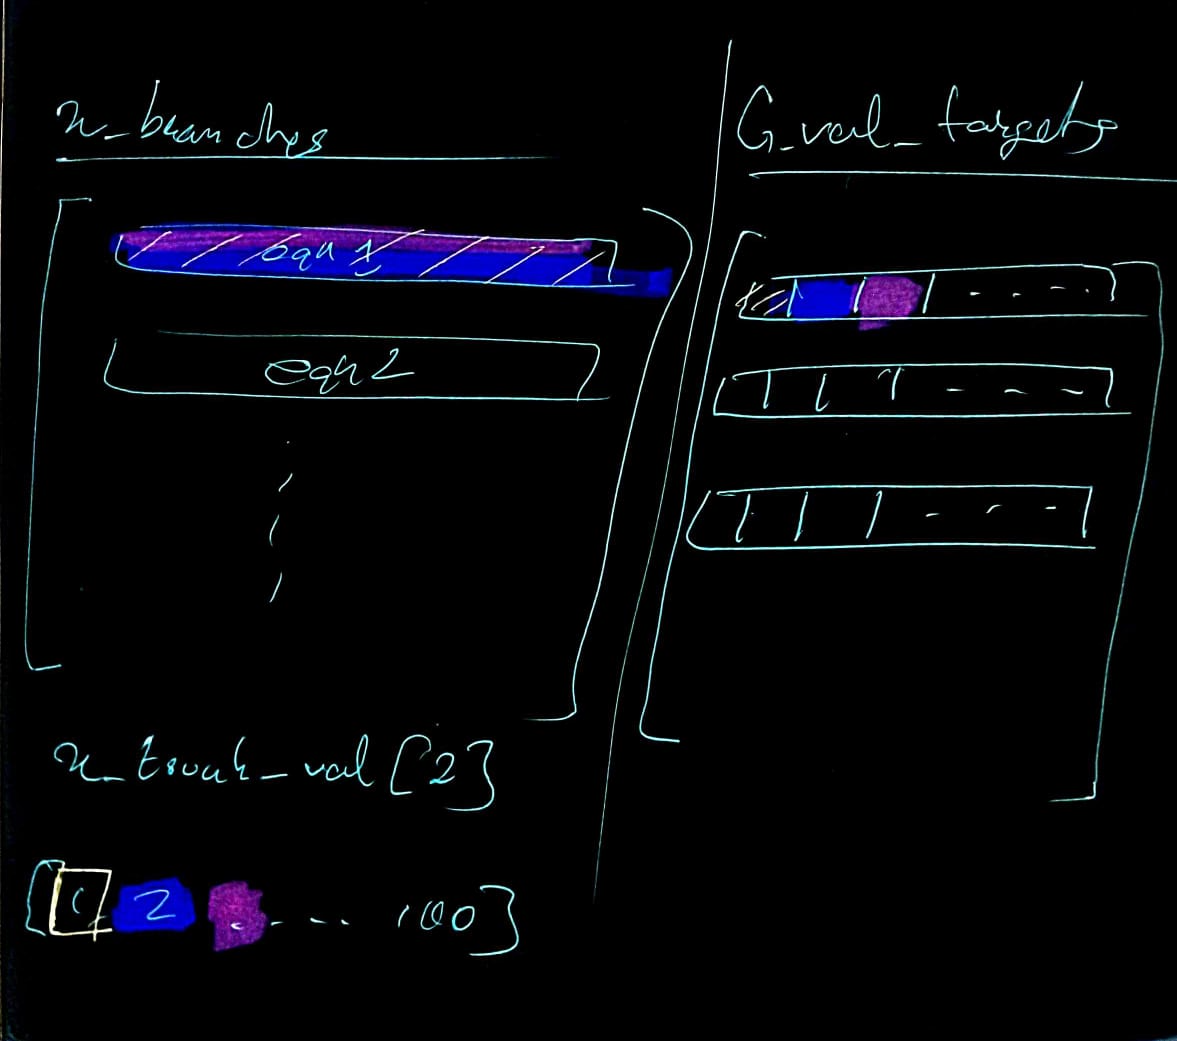

- for idx...
    - x_branch = x_branches[idx // len(x_trunk_val[2])]
    - x_trunk = x_trunk_val[2][idx % len(x_trunk_val[2])]
    - target = G_value_targets[idx // len(x_trunk_val[2])][idx % len(x_trunk_val[2])]

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split

class CubicPolynomialDataset(Dataset):
    def __init__(self):
        super().__init__()
        
        # Let's start by generating a bunch of random cubic polynomials coeffs and that of their derivatives
        domain_limits = [-100, 101]
        sampling_window = 10
        how_many_in_a_window = 20
        self.Ga = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])
        self.Gb = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])
        self.Gc = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])
        self.Gd = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])

        self.ua = 3*self.Ga
        self.ub = 2*self.Gb
        self.uc = self.Gc
        
        # Matrix of coefficients
        u_coeff_matrix = np.vstack((self.ua, self.ub, self.uc)).T
        G_coeff_matrix = np.vstack((self.Ga, self.Gb, self.Gc, self.Gd)).T

        # Sensor locations 
        self.num_sensors = 100
        self.x_sensor_locations = np.linspace(domain_limits[0], domain_limits[1], self.num_sensors)
        
        # x_trunk locations
        self.num_x_trunk_for_each_u = 100
        self.x_trunk_locations = np.linspace(domain_limits[0], domain_limits[1], self.num_x_trunk_for_each_u)
        
        # Matrix of variables
        self.x_branch_variable_matrix = np.vstack((self.x_sensor_locations**2,
                                              self.x_sensor_locations,
                                              np.ones((1, self.num_sensors))
                                            ))
        
        self.x_trunk_variable_matrix = np.vstack((self.x_trunk_locations**3,
                                             self.x_trunk_locations**2,
                                             self.x_trunk_locations,
                                             np.ones((1, self.num_x_trunk_for_each_u))
                                            )) 
        
        
        # Input / Output Matrices ~~
        
        self.x_branches = np.dot(u_coeff_matrix, self.x_branch_variable_matrix)  
        # each row here is a set of sensor point values for one function u  # we have a row for each of the polynomials we generated
        
        self.G_value_targets = np.dot(G_coeff_matrix, self.x_trunk_variable_matrix)
        # each row here is a series of target values for each x_trunk corresponding to one function G(u)
        
        
        # testing shapes
        # print(self.Ga.shape)
        # print(self.x_sensor_locations.shape)
        # print(self.x_branches.shape)
        # print(self.G_value_targets.shape)
        
        
    def __len__(self):
        return self.num_x_trunk_for_each_u * len(self.Ga)

    def __getitem__(self, idx):
        
        row = idx // self.num_x_trunk_for_each_u
        col = idx % self.num_x_trunk_for_each_u
        
        x_branch = self.x_branches[row]
        x_trunk = self.x_trunk_variable_matrix[2][col]
        
        target = self.G_value_targets[row][col]
        
        return torch.tensor(x_branch, dtype=torch.float32), torch.tensor(x_trunk, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)
    

# Now we train, save and evaluate ~~ 

In [4]:
batch_size = 2048
learning_rate = 0.01
num_epochs = 10000000

train_percentage = 0.8

dataset = CubicPolynomialDataset()
train_dataset, test_dataset = random_split(dataset, [int(train_percentage*len(dataset)), len(dataset) - int(train_percentage*len(dataset))])

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = YoOpNet()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
# print(device)

In [6]:

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    model.train()
    for x_branch, x_trunk, target in train_data_loader:
        # x_branch, x_trunk, target = x_branch.to(device), x_trunk.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(x_branch, x_trunk)
        train_loss = loss_fn(output, target)
        train_loss.backward()
        optimizer.step()
        
        print('.', end = '')
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_data_loader:
            x_branch, x_trunk, targets = batch
            outputs = model(x_branch, x_trunk)
            val_loss += loss_fn(outputs, targets).item()
    val_loss /= len(test_data_loader)
    
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss:.4f}')

.................Epoch 1/100000000000000000000, Training Loss: 484552472526848.0, Validation Loss: 599402810546585.6250


/home/takayuki/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([208])) that is different to the input size (torch.Size([208, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


.................Epoch 2/100000000000000000000, Training Loss: 577539957325824.0, Validation Loss: 587479773295411.2500
.................Epoch 3/100000000000000000000, Training Loss: 523957153300480.0, Validation Loss: 576498159321088.0000
.................Epoch 4/100000000000000000000, Training Loss: 586085331632128.0, Validation Loss: 618945562699366.3750
.................Epoch 5/100000000000000000000, Training Loss: 644677208375296.0, Validation Loss: 588869195215667.2500
.................Epoch 6/100000000000000000000, Training Loss: 465836783435776.0, Validation Loss: 571191653407129.6250
.................Epoch 7/100000000000000000000, Training Loss: 648194316828672.0, Validation Loss: 568350109754982.3750
.................Epoch 8/100000000000000000000, Training Loss: 593985521319936.0, Validation Loss: 596598901545369.6250
.................Epoch 9/100000000000000000000, Training Loss: 676398628864000.0, Validation Loss: 579332414950604.7500
.................Epoch 10/10000000000000

KeyboardInterrupt: 

In [7]:
577539957325824. - 611936068698112

-34396111372288.0